In [21]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('Airports2.csv')

In [95]:
a = df[df['Origin_airport'] == 'YIP']['Seats'].count()
b = df[df['Destination_airport'] == 'YIP']['Seats'].count()
a+b

14460

In [91]:
freq = df['Origin_airport'].value_counts()
unique_fly = freq[freq == 1].index
# df.iloc[unique_fly]['Origin_airport']
freq[freq == max(freq)].index

Index(['ORD'], dtype='object')

In [25]:
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [29]:
df.shape

(3606803, 15)

In [26]:
df.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.599849e+06,3.599849e+06,3.599996e+06,3.599996e+06
mean,2.688910e+03,4.048297e+03,3.722890e+01,6.973190e+02,5.871502e+06,5.897982e+06,3.775029e+01,-9.186178e+01,3.774091e+01,-9.183433e+01
std,4.347617e+03,6.200871e+03,4.961970e+01,6.044165e+02,7.858062e+06,7.906127e+06,5.765453e+00,1.653773e+01,5.736556e+00,1.647228e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.090000e+02,1.560000e+02,2.000000e+00,2.730000e+02,1.030597e+06,1.025470e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.118000e+03,1.998000e+03,2.500000e+01,5.190000e+02,2.400193e+06,2.400193e+06,3.885210e+01,-8.775240e+01,3.885210e+01,-8.775240e+01
75%,3.503000e+03,5.370000e+03,5.500000e+01,9.270000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [31]:
df.isna().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [12]:
df.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

Numero di nodi (aeroporti): 727
Numero di archi (tratte): 36719


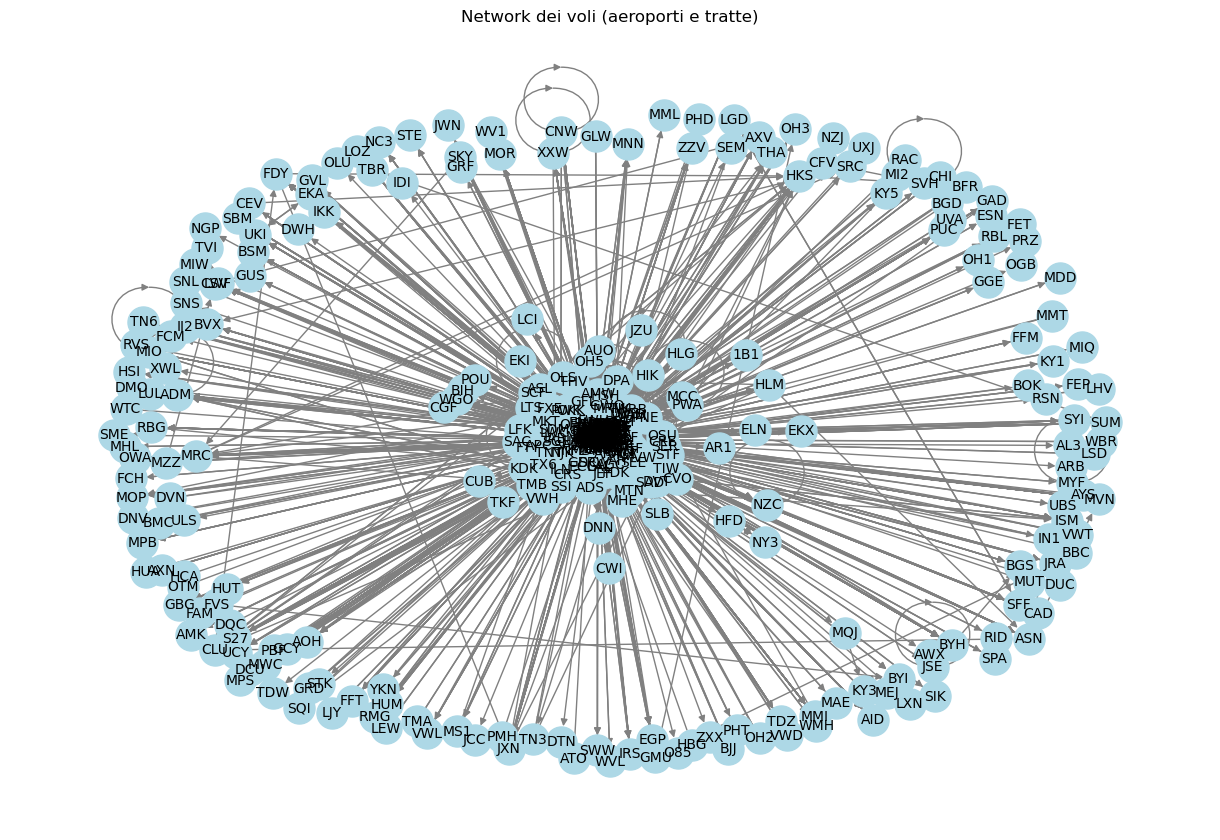

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
G_dir = nx.DiGraph()

origin_airports = df['Origin_airport'].unique()
destination_airports = df['Destination_airport'].unique()
all_airports = set(origin_airports).union(destination_airports)

G_dir.add_nodes_from(all_airports)  # Aggiungi tutti gli aeroporti come nodi

# Gli archi rappresentano le tratte (Origin_airport -> Destination_airport)
treated_edges = df.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
for row in treated_edges.itertuples(index=False):
    origin = row.Origin_airport
    destination = row.Destination_airport
    passengers = row.Passengers
    G_dir.add_edge(origin, destination, weight=passengers)  # Aggiungi l'arco con il peso


# 4. Visualizza alcune informazioni sul grafo
print(f"Numero di nodi (aeroporti): {G_dir.number_of_nodes()}")
print(f"Numero di archi (tratte): {G_dir.number_of_edges()}")


# 5. Visualizza il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_dir, k=0.15)  # Disposizione dei nodi
nx.draw(
    G_dir,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)
plt.title("Network dei voli (aeroporti e tratte)")
plt.show()

Numero di nodi (aeroporti): 727
Numero di archi (tratte): 23260


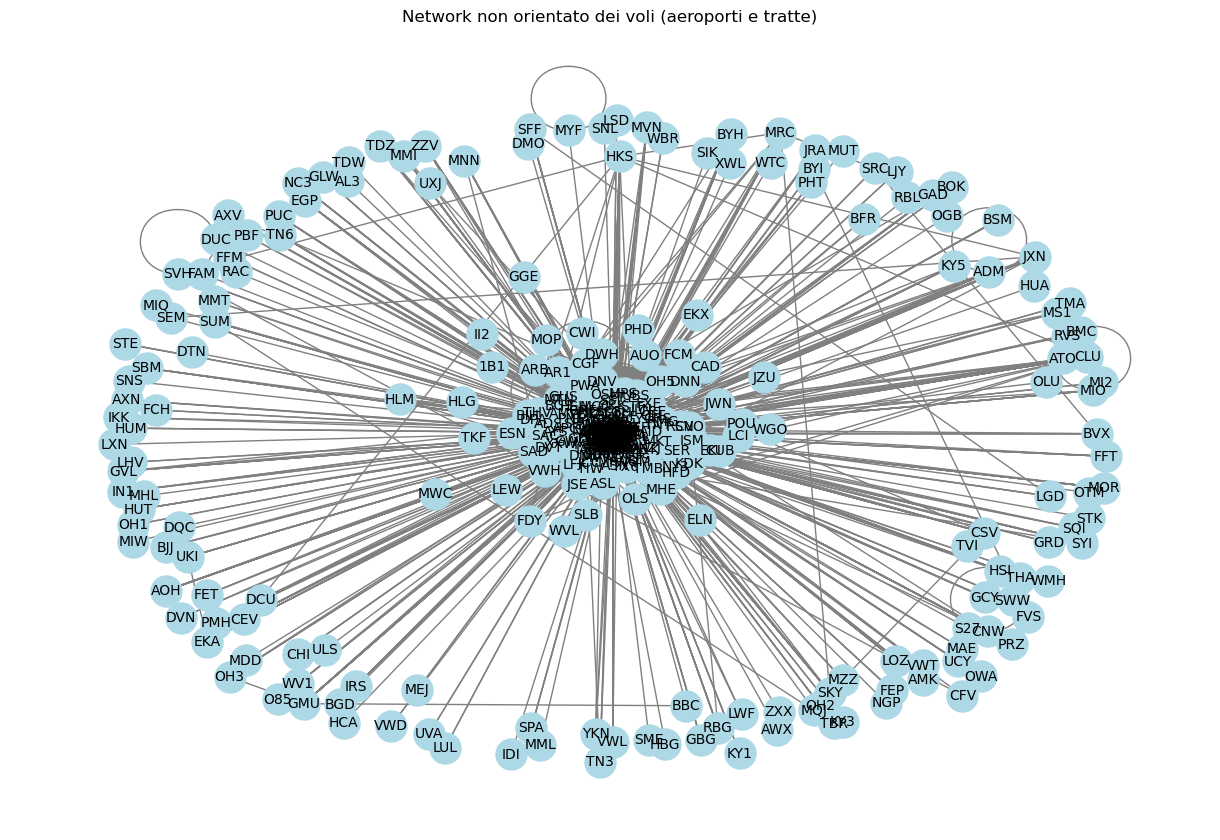

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Crea un grafo non orientato
G_no_dir = nx.Graph()  # Cambiato da DiGraph a Graph

# 2. Raccogli tutti gli aeroporti (nodi)
origin_airports = df['Origin_airport'].unique()
destination_airports = df['Destination_airport'].unique()
all_airports = set(origin_airports).union(destination_airports)

G_no_dir.add_nodes_from(all_airports)  # Aggiungi tutti gli aeroporti come nodi

# 3. Calcola i pesi delle tratte (archi)
treated_edges = df.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
for row in treated_edges.itertuples(index=False):
    origin = row.Origin_airport
    destination = row.Destination_airport
    passengers = row.Passengers

    # Se l'arco esiste già, somma i pesi
    if G_no_dir.has_edge(origin, destination):
        G_no_dir[origin][destination]['weight'] += passengers
    else:
        G_no_dir.add_edge(origin, destination, weight=passengers)  # Aggiungi l'arco con il peso

# 4. Visualizza alcune informazioni sul grafo
print(f"Numero di nodi (aeroporti): {G_no_dir.number_of_nodes()}")
print(f"Numero di archi (tratte): {G_no_dir.number_of_edges()}")

# 5. Visualizza il grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_no_dir, k=0.15)  # Disposizione dei nodi
nx.draw(
    G_no_dir,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)
plt.title("Network non orientato dei voli (aeroporti e tratte)")
plt.show()

In [17]:
# print(nx.is_connected(G_dir))
print(nx.is_connected(G_no_dir))

True


# 2. Nodes' Contribution

### Centrality Analysis in a Flight Network

In this analysis, we explored the structural importance of airports within a flight network by calculating centrality measures for each node and visualizing key results. The following steps summarize the approach:

1. **`analyze_centrality(flight_network, airport)`**:  
   This function computes centrality measures for a specific airport using precomputed dictionaries for each metric:  
   - **Betweenness Centrality**: Measures how often the airport appears on the shortest paths between other airports. Calculated using `calculate_betweenness_centrality`.  
   - **Closeness Centrality**: Quantifies how efficiently an airport can reach all other nodes. Calculated using `calculate_closeness_centrality`.  
   - **Degree Centrality**: Simply counts the number of direct connections (neighbors) an airport has. Calculated using `numbers_neighbors`.  
   - **PageRank**: Assesses the "importance" of an airport based on its incoming connections and their weights. Calculated using `calculate_pagerank`.

2. **Visualization with `plot_top_metric`**:  
   We used the `plot_top_metric` function to focus on the top 5 airports for any given centrality metric.  
   This function creates a bar plot showing the airports with the highest values for a specified metric, helping to visually identify the most influential nodes in the network.

By combining these tools, the analysis provides both numerical results for individual airports and visual insights into the most critical nodes across the network.

In [5]:
import Functions.centrality as cn

In [10]:
# Computing all the dictionaries with the metrics for each airport, and a df with the metrics for the requested airport
centrality_df, betweenness_centr, closeness_centrality, degree_centrality, pageranks = cn.analyze_centrality(G_dir, G_no_dir, 'BOS')

In [7]:
# DataFrame with metrics for the airport
centrality_df

,Airport,Betweenness Centrality,Betweenness Percentile,Closeness Centrality,Closeness Percentile,Degree Centrality,Degree Percentile,Pagerank,Pagerank Percentile
0,BOS,0.014314,96.973865,0.591205,95.185695,228,96.286107,0.012107,97.661623


Here we can see an exemple for the metric for an airport that we wanted to analyze. Furthermore, we have also added the percentile of the metric of the airport in question compared to those of all the other airports, in order to have a clearer idea of ​​the actual 'centrality' of the airport compared to all the others. The numbers of the metrics alone would otherwise be slightly complicated to interpret.

We can see how the dictionary with all the metrics looks for some elements.

In [57]:
# A part of the dictonary about betweenness_centr
list(betweenness_centr.items())[:10]

[('VEL', 0.0),
 ('RSN', 0.0),
 ('PGD', 2.4400305876107304e-05),
 ('JRB', 9.247488800868394e-06),
 ('HYS', 7.259879358473925e-05),
 ('MIQ', 0.0),
 ('LUL', 0.0),
 ('HVN', 5.452627276845974e-05),
 ('WTC', 0.0),
 ('SBM', 1.55727582625162e-07)]

In [58]:
# A part of the dictonary about closeness_centrality
list(closeness_centrality.items())[:10]

[('VEL', 0.38392384981491273),
 ('RSN', 0.32338530066815147),
 ('PGD', 0.4376130198915009),
 ('JRB', 0.3861702127659574),
 ('HYS', 0.4160458452722063),
 ('MIQ', 0.3833157338965153),
 ('LUL', 0.39759036144578314),
 ('HVN', 0.4603677869372226),
 ('WTC', 0.278267535454197),
 ('SBM', 0.42984014209591476)]

In [59]:
# A part of the dictonary about degree_centrality
list(degree_centrality.items())[:10]

[('VEL', 6),
 ('RSN', 0),
 ('PGD', 18),
 ('JRB', 5),
 ('HYS', 15),
 ('MIQ', 1),
 ('LUL', 1),
 ('HVN', 42),
 ('WTC', 1),
 ('SBM', 6)]

In [60]:
# A part of the dictonary about pageranks
list(pageranks.items())[:10]

[('VEL', 0.00022177108143513378),
 ('RSN', 0.00021815955472033216),
 ('PGD', 0.0002536212483496803),
 ('JRB', 0.00021896150875126303),
 ('HYS', 0.0003289257610615344),
 ('MIQ', 0.00021777815973266786),
 ('LUL', 0.00021777815973266786),
 ('HVN', 0.00024911036207779736),
 ('WTC', 0.00021777815973266786),
 ('SBM', 0.00021777815973266786)]

Now that we have an idea we can go and see which airports occupy the first 5 positions for each metric, so which are the most central for each evaluation metric that we have implemented.

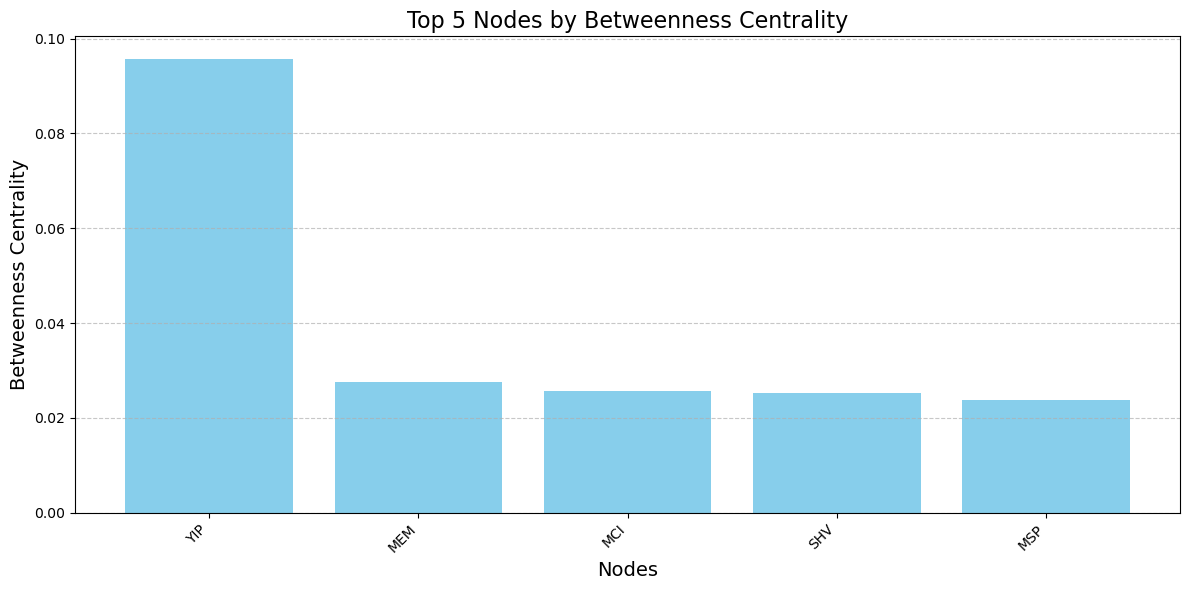

In [61]:
cn.plot_top_metric(betweenness_centr, 'Betweenness Centrality', top_n = 5)

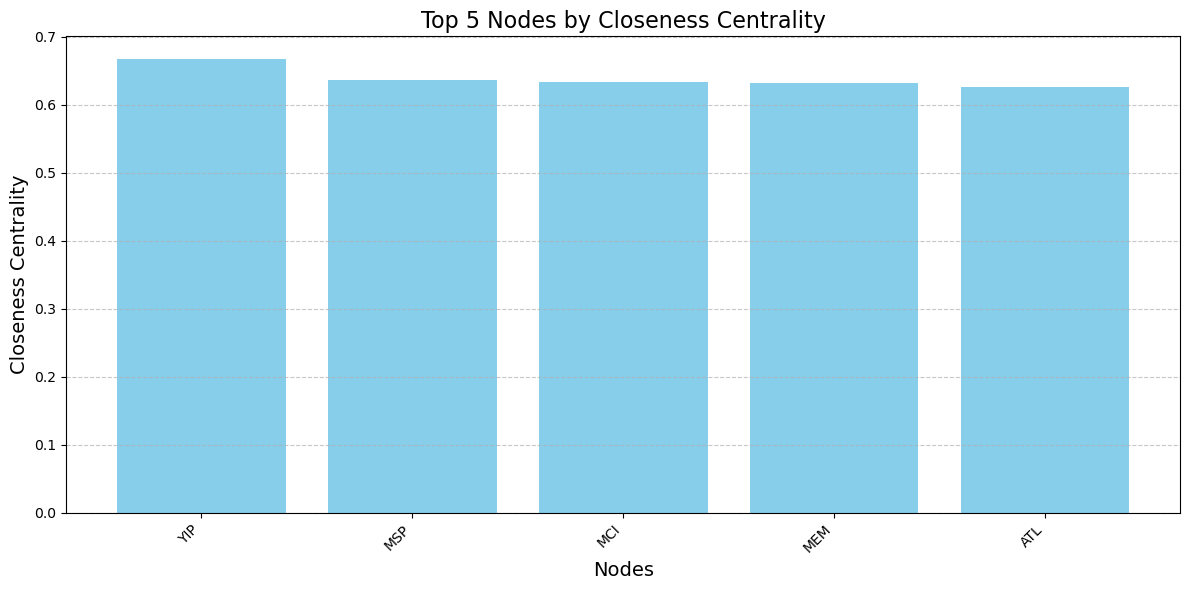

In [62]:
cn.plot_top_metric(closeness_centrality, 'Closeness Centrality', top_n= 5)

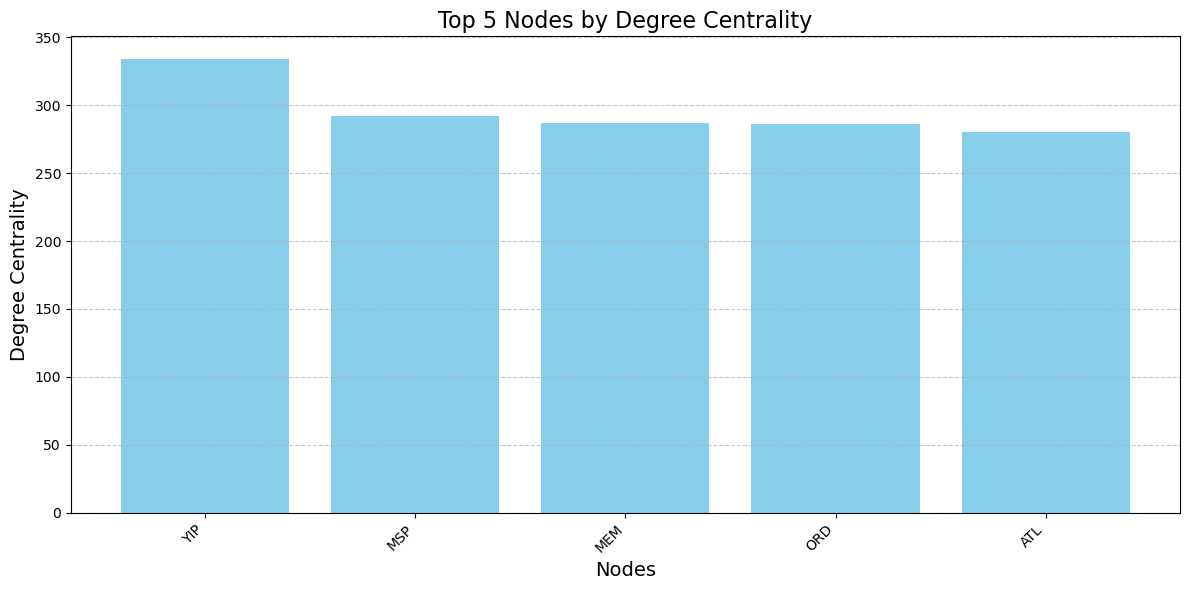

In [63]:
cn.plot_top_metric(degree_centrality, 'Degree Centrality', top_n=5)

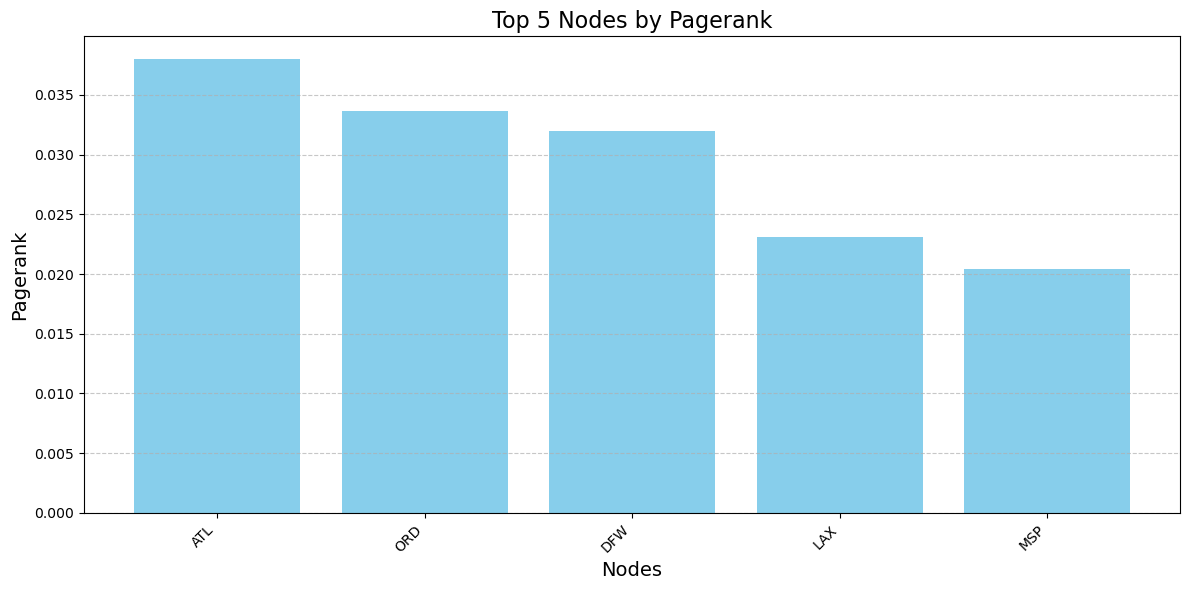

In [64]:
cn.plot_top_metric(pageranks, 'Pagerank', top_n= 5 )

### LLM questions 

Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

#### Here are some alternative centrality measures that might be relevant for analyzing the airport network:

- Eigenvector Centrality:
    Measures how important a node is based on the importance of its neighbors.
    Particularly useful when certain airports are connected to other "high-rank" airports.

- Katz Centrality:
    Similar to Eigenvector Centrality, but assigns decreasing importance to connections further away.
    Useful for capturing the influence of airports that are not directly connected.

- Harmonic Centrality:
    A variation of Closeness Centrality that better handles disconnected graphs by calculating the reciprocal of the distance only for reachable nodes.
    Useful when the network contains isolated sub-networks.

- Flow Centrality:
    Measures how critical a node is in facilitating flows (e.g., passengers or goods) across the network.
    Relevant for analyzing how traffic moves through airports.

- Edge Betweenness Centrality:
    Calculates centrality for edges (connections) rather than nodes.
    Helps identify critical routes that, if removed, would disrupt traffic between regions of the network.

#### How to Check if the Results are Trustworthy

- Compare with Other Studies:
    Look for academic papers or reports related to the analysis of similar networks (transportation, infrastructure, etc.).
    Verify if the suggested measures align with those used in previous studies.

- Intuitive Analysis and Interpretation:
    Each centrality measure should have a clear interpretation in the context of the airport network. For example:
        Eigenvector Centrality should identify airports with highly strategic connections.
        Flow Centrality should highlight airports critical for passenger transit.

- Statistical Validation:
    Apply the new centrality measures to the network and compare the results with already computed ones (Betweenness, Closeness, Degree, PageRank).
    Check for significant correlations or differences:
        Compute correlation coefficients (e.g., Pearson or Spearman) between the centralities.

- Network Experiments:
    Remove nodes or edges with high centrality (according to the new measure) and observe the impact on network connectivity or capacity.
    If significant impacts are observed, it supports the relevance of the measure.

- Consult Domain Experts:
    Seek feedback from experts in airport networks or transportation to evaluate the validity of the suggested measures in a real-world context.

In [6]:
# Calculate Flow Centrality
flow_centrality = cn.calculate_flow_centrality(G_no_dir)

# Output the Flow Centrality scores for a semple of nodes 
print("Flow Centrality:")
list(flow_centrality.items())[:10]

Flow Centrality:


[('LOZ', 0.0),
 ('LSE', 0.02174218675786074),
 ('EDF', 0.008929419587726799),
 ('SWW', 0.0),
 ('NGP', 0.0),
 ('CEC', 0.004593901396409234),
 ('BYH', 0.0034577752446091005),
 ('FLG', 0.009856559323643963),
 ('ATW', 0.0458098223615465),
 ('EUG', 0.08796048256863305)]

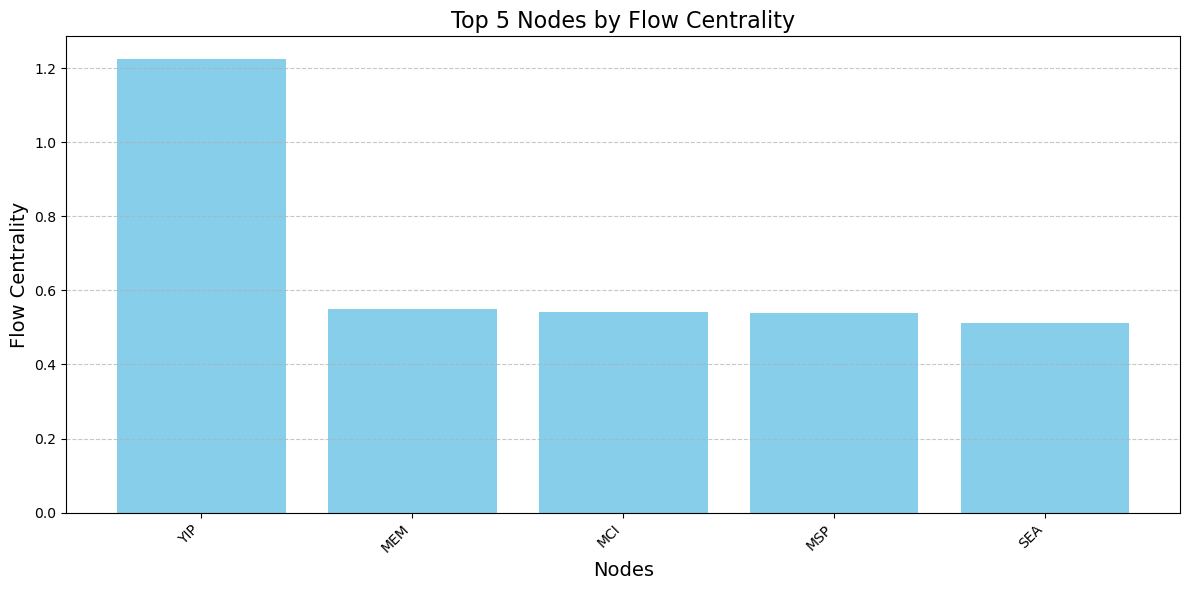

In [7]:
cn.plot_top_metric(flow_centrality, 'Flow Centrality', top_n = 5)

### Similarities and Differences between Flow Centrality and Betweenness Centrality

Both **Flow Centrality** and **Betweenness Centrality** measure the importance of a node in terms of its involvement in the shortest paths between other nodes. The key similarity is that they both focus on how often a node appears on the shortest paths in the graph, which reflects the node's centrality and influence on communication within the network.

#### Differences:
- **Flow Centrality** counts how many times a node appears in the shortest paths between all pairs of nodes, without considering the control or flow of information. It's a simpler measure, focusing solely on frequency of appearance.
- **Betweenness Centrality**, on the other hand, measures how often a node acts as a bridge, influencing the flow between other nodes. It takes into account the dependency of other nodes' paths on the node in question.

Because of these differences in focus and complexity, **Flow Centrality** will be compared with **Betweenness Centrality** to assess the nuances in how each metric captures node importance.
We can start computing the Correlation, as suggested before with statistical validations.

In [22]:
metrics = pd.DataFrame({
    'airport': list(flow_centrality.keys()),
    'flow_centrality': list(flow_centrality.values()),
    'betweenness_centrality': list(betweenness_centr.values())
})

correlation, p_value = pearsonr(metrics['flow_centrality'], metrics['betweenness_centrality'])

print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson Correlation: 0.9293056049563915
P-value: 7.299557e-316
The correlation is statistically significant.


As we could immagine, the correlation is very high, that means that those metrics are really similar. We can try to see the differences between them by having a graphical representation of their distributions with two histograms.

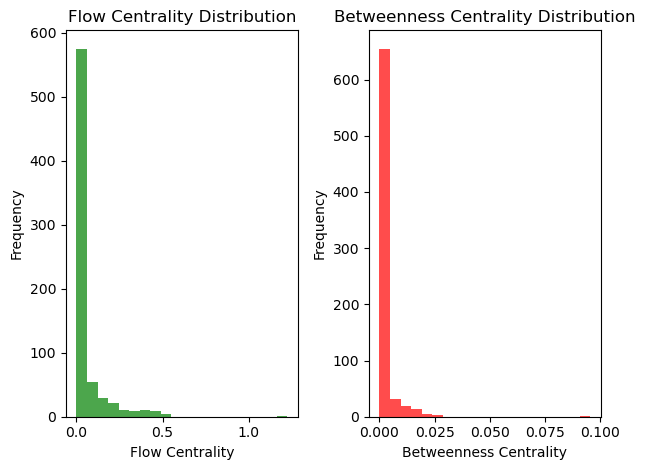

In [19]:
# Histogram for Flow Centrality
plt.subplot(1, 2, 1)
plt.hist(metrics['flow_centrality'], bins=20, color='green', alpha=0.7)
plt.title('Flow Centrality Distribution')
plt.xlabel('Flow Centrality')
plt.ylabel('Frequency')

# Histogram for Betweenness Centrality
plt.subplot(1, 2, 2)
plt.hist(metrics['betweenness_centrality'], bins=20, color='red', alpha=0.7)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From this graph one thing is clear, the distributions are almost identical, this confirms the high correlation, that is, the values ​​tend to move in step. But paying attention to the values ​​on the x, we can notice how for both the concentration is high for the values ​​close to zero, but for the Flow Centrality the values ​​go up to larger numbers, unlike the Betweenness Centrality which has more contained values.
Just observe that the highest value for both is the same, the YIP airport, but it has a Flow Centrality of about 1.2, and a Betweenness Centrality equal to just under 0.1. The other values ​​in the Flow slightly exceed 0.5, while in the Betweenness they barely exceed 0.025.

# 4. Airline Network Partitioning

In order to answer at this question of the homework we have chosen between some of the disconnection algorithm for graph to find the best one for our case.

The Graph we are using is a non-directed one,  and that's beacuse if we need to separate the flight network, doesn't really make sense to consider flights directions. These, being arcs that connect two airports, are passable in both directions, and for this reason the graph, if it has to be separated, needs to be considered undirected.

To find the best partitioning, we can use several disconnection algorithms, like the Minimum Cut Algorithm (Edmonds-Karp), the Maximum Flow Algorithm (Ford-Fulkerson), or the Graph Cut Algorithm (Karger's Algorithm). The Karger's Algorithm is a simple and efficient algorithm for finding the minimum cut in a graph, but it may not always give the best solution, due to its probabilistic and non-'certain' nature.

We've tried some of them, and the best one resulted to be the Minimum Cut Algorithm (Edmonds-Karp).

### *The Edmonds-Karp algorithm*

The Edmonds-Karp algorithm is an implementation of the Ford-Fulkerson method for finding the maximum flow in a flow network.  Flow is sent from a source node to a sink node along the edges, and the objective is to maximize the flow while respecting the capacities. 

The algorithm repeatedly uses breadth-first search (BFS) to find augmenting paths in the residual graph, which is a modified version of the graph reflecting the remaining available capacities. Once an augmenting path is found, the flow is increased along that path by the bottleneck capacity (the smallest available capacity along the path), and the residual graph is updated. This process continues until no more augmenting paths can be found, at which point the flow is maximized.

In the context of the maximum flow and minimum cut theorem, the maximum flow value is equal to the minimum cut capacity. After finding the maximum flow, a BFS is used on the residual graph to identify reachable nodes from the source. The minimum cut consists of the edges going from any node in the reachable set to those outside it. The capacity of this cut is equal to the maximum flow.

Additionally, I adapted the algorithm for an undirected graph by treating the flow in both directions of an edge as contributing to the total flow. This adjustment ensures that the algorithm works seamlessly even for undirected graphs, where flow can move in both directions.



In [4]:
import Functions.disconnection as ds

In [41]:
# setting two random airports as source and sink for our algorithm
origin_airports = df['Origin_airport'].unique()
destination_airports = df['Destination_airport'].unique()
all_airports = set(origin_airports).union(destination_airports)
all_airports = sorted(list(all_airports))

source = all_airports[0]  
sink = all_airports[-1]  
source, sink

('1B1', 'ZZV')

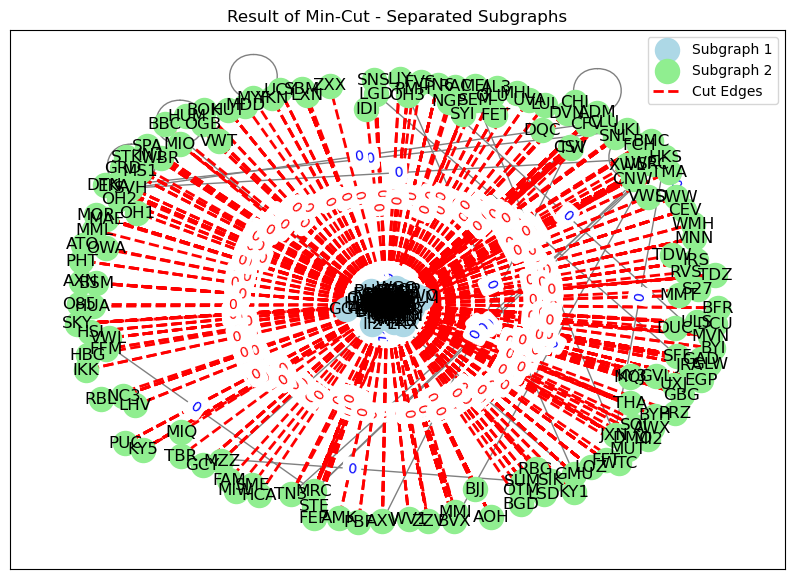

Cut edges: [('JRB', 'JRA'), ('PDT', 'LGD'), ('PDT', 'SFF'), ('MFD', 'SKY'), ('RFD', 'CLU'), ('RFD', 'DVN'), ('RFD', 'GVL'), ('RFD', 'IRS'), ('RFD', 'JXN'), ('RFD', 'OH2'), ('RFD', 'PMH'), ('RFD', 'MVN'), ('RFD', 'RVS'), ('FAR', 'VWL'), ('PIA', 'MVN'), ('PIA', 'SUM'), ('FSM', 'CLU'), ('FSM', 'MRC'), ('FSM', 'SBM'), ('BOS', 'ADM'), ('DFW', 'CHI'), ('DFW', 'CNW'), ('DFW', 'ADM'), ('DFW', 'MRC'), ('DFW', 'HKS'), ('JMS', 'VWL'), ('STL', 'CLU'), ('STL', 'HKS'), ('STL', 'IRS'), ('STL', 'JXN'), ('STL', 'LOZ'), ('STL', 'MRC'), ('STL', 'SBM'), ('STL', 'ADM'), ('STL', 'AXV'), ('STL', 'FAM'), ('STL', 'MIO'), ('STL', 'MVN'), ('STL', 'SVH'), ('STL', 'VWT'), ('SAT', 'ADM'), ('SAT', 'CLU'), ('SAT', 'CNW'), ('SAT', 'EGP'), ('SAT', 'MRC'), ('SAT', 'NGP'), ('SAT', 'UVA'), ('BTV', 'GMU'), ('BTV', 'LWF'), ('BTV', 'SKY'), ('ATW', 'BVX'), ('ATW', 'STE'), ('LMT', 'RBG'), ('RIC', 'IRS'), ('ANC', 'CHI'), ('ANC', 'CNW'), ('ANC', 'MDD'), ('BGS', 'BYH'), ('PAH', 'JXN'), ('RDD', 'EKA'), ('RDD', 'UKI'), ('GSP', 'GMU

In [42]:
# finding the min-cut
cut_edges, subgraph1, subgraph2, max_flow, cut_weight = ds.edmonds_karp_min_cut_custom(G_no_dir, source, sink)

# representing the graph with the cutted edges and the two subgraphs colored in different ways
ds.visualize_cut_result(G_no_dir, cut_edges, subgraph1, subgraph2)
print("Cut edges:", cut_edges)
print("Subgraph 1:", subgraph1)
print("Subgraph 2:", subgraph2)
print("Max flow:", max_flow)
print("Cut weight:", cut_weight)

In this case the smallest cut actually coincides with the maxflow, and we obtain two separate subgraphs with the minimum cost, 0. Two distinct subgraphs have been created, which are distinguished by two different colors. To verify the correct functioning of our algorithm, let's test it on a simpler graph.

So we perform a test on a smaller and more visible graph, in order to understand the correct functioning of our algorithm.

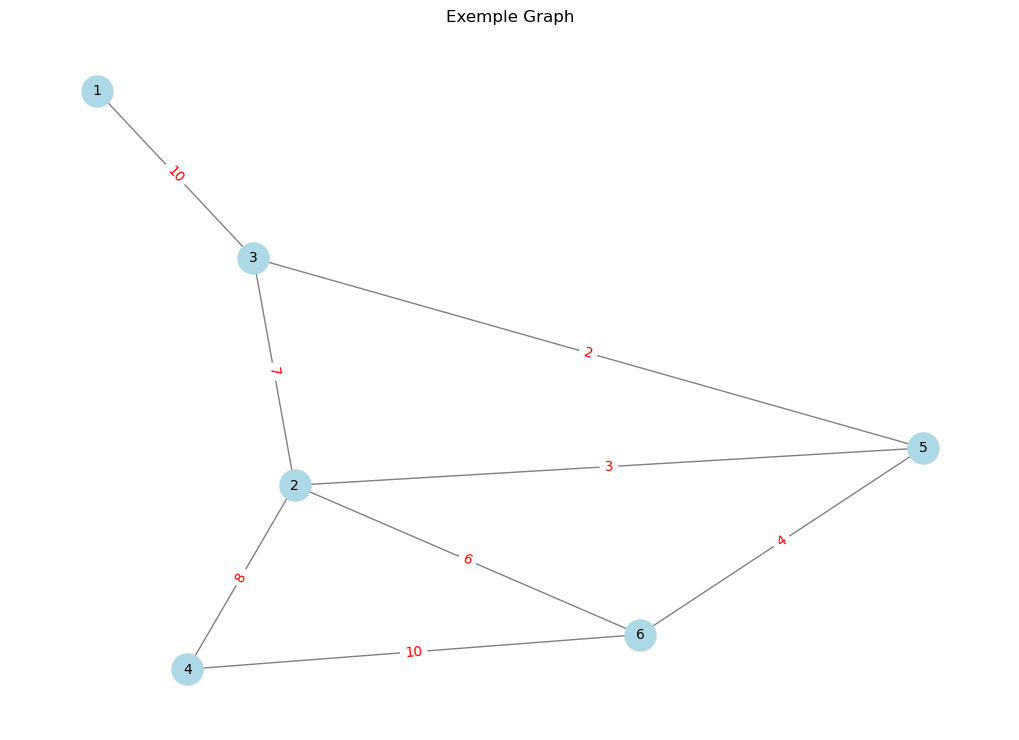

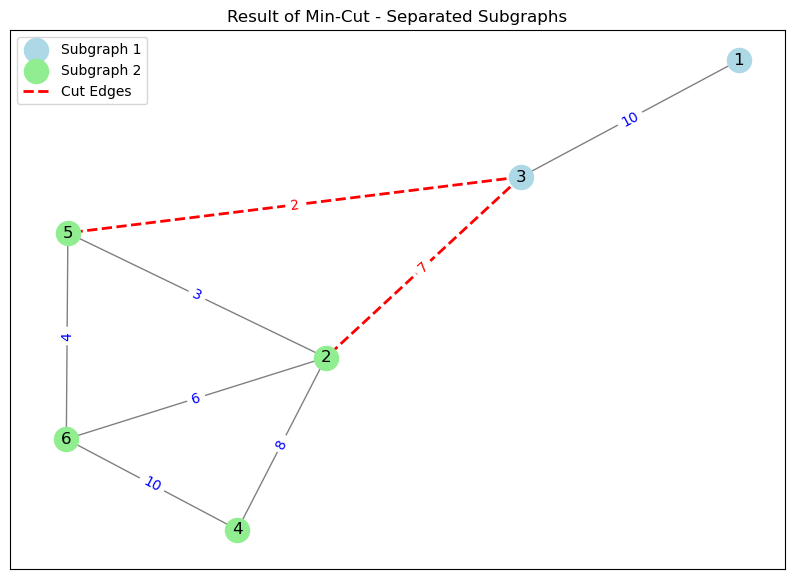

Cut edges: [(3, 2), (3, 5)]
Subgraph 1: {1, 3}
Subgraph 2: {2, 4, 5, 6}
Max flow: 9
Cut weight: 9


In [19]:

G_test = ds.create_test_graph()

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_test, k=0.15)  
nx.draw(
    G_test,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    edge_color="gray",
    font_size=10,
)

edge_labels = nx.get_edge_attributes(G_test, "weight")  
nx.draw_networkx_edge_labels(G_test, pos, edge_labels=edge_labels, font_color="red")
plt.title("Exemple Graph")
plt.show()

cut_edges, subgraph1, subgraph2, max_flow, cut_weight = ds.edmonds_karp_min_cut_custom(G_test, source=1, sink=6)


ds.visualize_cut_result(G_test, cut_edges, subgraph1, subgraph2)
print("Cut edges:", cut_edges)
print("Subgraph 1:", subgraph1)
print("Subgraph 2:", subgraph2)
print("Max flow:", max_flow)
print("Cut weight:", cut_weight)

In this case the algorithm works and the cut found seems to be optimal.

However, surely by changing the start and end nodes other cuts inside the graph are found, some better and some worse. Despite this, in the example of the main graph, a cut with a weight of 0 was found. So, surely even if there are other cuts that divide the graph into two subgraphs that cost 0, the one found remains one of the best options like all the others.

# 5

In [10]:
from community import community_louvain

# Identifica le comunità
partition = community_louvain.best_partition(G_no_dir, random_state=42)

# Crea un dizionario con comunità e città
communities = {}
for city, community in partition.items():
    communities.setdefault(community, []).append(city)


In [11]:
communities__ = []
for city, community in partition.items():
    if community not in communities__:
        communities__.append((community))

print(len(communities__))


160


In [12]:
communities

{0: ['SEE', 'MCE', 'VGT', 'VIS', 'BIH', 'SAD', 'DVT'],
 86: ['VWH',
  'AR1',
  'VCT',
  'TKF',
  'LRD',
  'MLU',
  'JAN',
  'SHV',
  'GPT',
  'RUI',
  'DNE',
  'BFM',
  'MTJ',
  'STJ',
  'OFF',
  'ELP',
  'GGG',
  'GRF',
  'SPS',
  'COS',
  'FTW',
  'ACT',
  'CRS',
  'HOB',
  'MGY',
  'GLH',
  'NBG',
  'MSY',
  'EDF',
  'TUP',
  'LIT',
  'TNT',
  'DFW',
  'CRP',
  'SAT',
  'LBB',
  'EFD',
  'PIB',
  'JEF',
  'TUL',
  'BRO',
  'ESF',
  'XNA',
  'SAF',
  'RIV',
  'BIF',
  'LSF',
  'MXF',
  'IAH',
  'PUB',
  'TCL',
  'GWO',
  'OPF',
  'ICT',
  'LWC',
  'ASL',
  'BGS',
  'ROW',
  'PDK',
  'BTR',
  'LFK',
  'LRU',
  'ABQ',
  'AFW',
  'FMN',
  'IAB',
  'SKF',
  'GRK',
  'OCF',
  'HRO',
  'ELD',
  'LCH',
  'NJK',
  'MHE',
  'TYR',
  'JBR',
  'TCM',
  'BPT',
  'MTN',
  'SWO',
  'CVN',
  'FYV',
  'SJT',
  'TX6',
  'TSM',
  'STF',
  'LAW',
  'ARA',
  'LAM',
  'MCF',
  'SVC',
  'AMA',
  'HOT',
  'SVN',
  'CNM',
  'DRT',
  'BHM',
  'OKC',
  'ALM',
  'CLL',
  'POB',
  'MEM',
  'LFT',
  'FSM',
  'SR

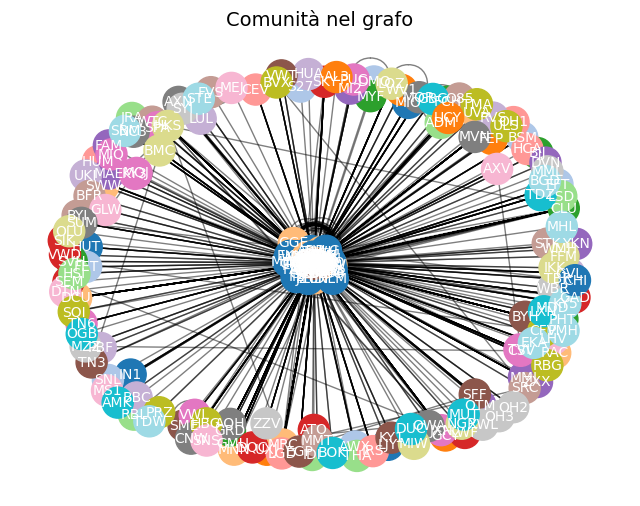

In [13]:
# Ottieni i colori in base alla comunità dalla partition
node_colors = [partition[node] for node in G_no_dir.nodes()]

# Disegna il grafo con le comunità
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_no_dir, seed=42)  # Layout del grafo
nx.draw_networkx_nodes(G_no_dir, pos, node_size=500, node_color=node_colors, cmap=plt.cm.tab20)  # Nodi colorati
nx.draw_networkx_edges(G_no_dir, pos, alpha=0.5)  # Archi
nx.draw_networkx_labels(G_no_dir, pos, font_size=10, font_color="white")  # Etichette

# Titolo e legenda
plt.title("Comunità nel grafo", fontsize=14)
plt.axis("off")  # Nasconde gli assi
plt.show()

In [14]:

def analyze_communities(G, c1, c2):
    """
    Analizza la rete di volo, identifica le comunità e restituisce:
    - Il numero di comunità totali
    - Le città che appartengono a ciascuna comunità
    - Se le città c1 e c2 appartengono alla stessa comunità o meno
    """

   # Identificazione delle comunità usando l'algoritmo Louvain
    partition = community_louvain.best_partition(G, random_state=42)
    
    # Numero di comunità
    num_communities = len(set(partition.values()))
    
    # Identifica le comunità che contengono c1 e c2
    communities_c1 = {comm for city, comm in partition.items() if city == c1}
    communities_c2 = {comm for city, comm in partition.items() if city == c2}
    
    # Determina se c1 e c2 appartengono alla stessa comunità
    same_community = communities_c1 == communities_c2
    
    common_community = list(communities_c1.intersection(communities_c2)) if same_community else None

    # Visualizzazione del grafo con colorazione delle comunità
    pos = nx.spring_layout(G)  # Layout per il grafo
    plt.figure(figsize=(10, 8))

    # Creazione di un elenco di colori per ciascuna comunità
    cmap = plt.cm.get_cmap("tab20", num_communities)  # Usa una tavolozza di colori

    # Disegna il grafo, colorando i nodi per comunità
    nx.draw(G, pos, with_labels=True, node_color=[cmap(partition[node]) for node in G.nodes], node_size=500, font_size=10, font_weight='bold')
    
    # Mostra la visualizzazione del grafo
    plt.title("Flight Network with Communities Highlighted")
    plt.show()

    if common_community:
            # Filtra i nodi che appartengono alla comunità comune
            common_nodes = [node for node, comm in partition.items() if comm == common_community[0]]
            
            # Crea un sottogruppo del grafo con solo i nodi comuni
            G_common = G.subgraph(common_nodes)
            
            # Visualizzazione del grafo con solo i nodi della comunità comune
            plt.figure(figsize=(10, 8))
            nx.draw(G_common, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10, font_weight='bold')
            plt.title(f"Graph of the Common Community: {common_community[0]}")
            plt.show()

    return {
        "num_communities": num_communities,
        "communities_c1": list(communities_c1),
        "communities_c2": list(communities_c2),
        "same_community": same_community,
        "common_community": common_community
    }

C:\Users\User\AppData\Local\Temp\ipykernel_15448\3792620430.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", num_communities)  # Usa una tavolozza di colori


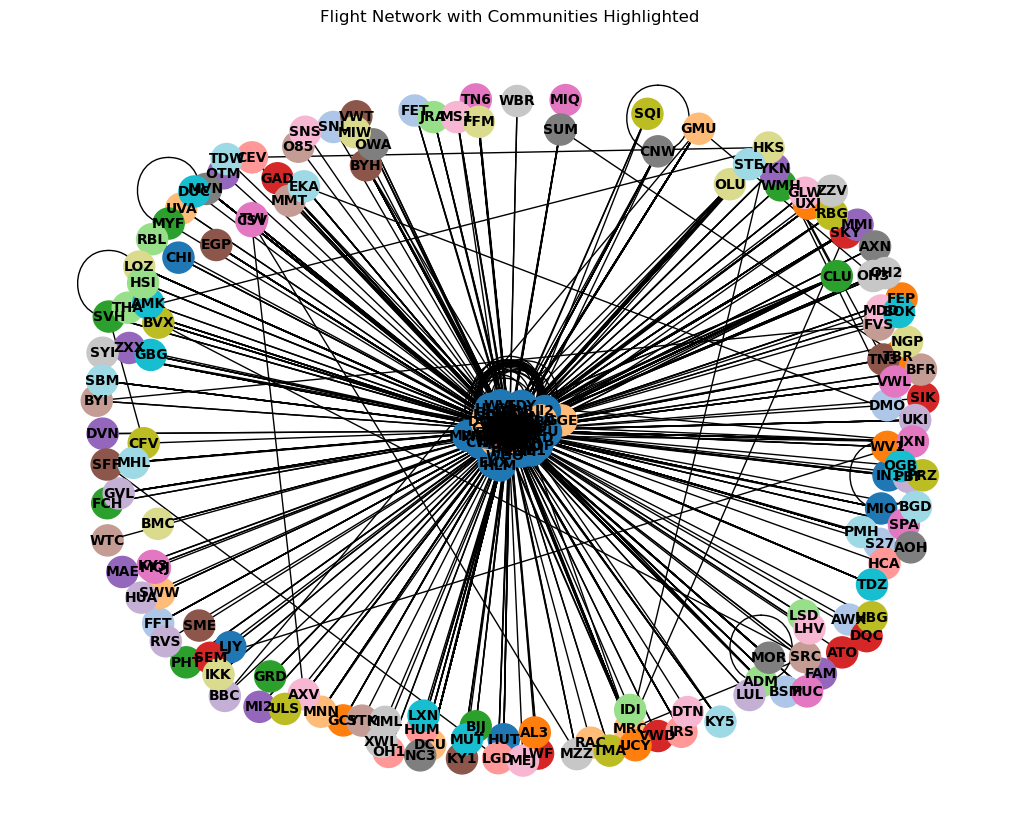

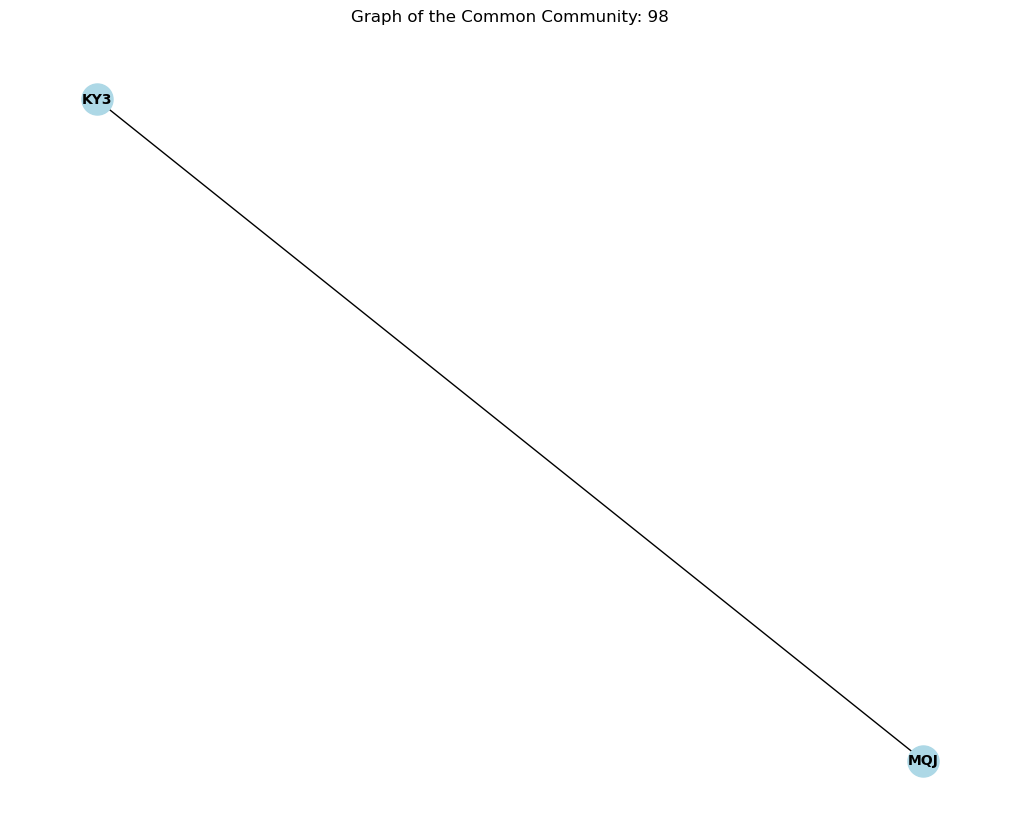

{'num_communities': 160,
 'communities_c1': [98],
 'communities_c2': [98],
 'same_community': True,
 'common_community': [98]}

In [15]:
analyze_communities(G_no_dir, 'MQJ', 'KY3')